In [1]:
# Source paper: https://pubs.aip.org/aip/jrse/article/13/2/025301/926842

In [2]:
import csv
from cvxpy import *
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

Reading: Building Load Data/GeiselLibrary.csv
(87797, 3)


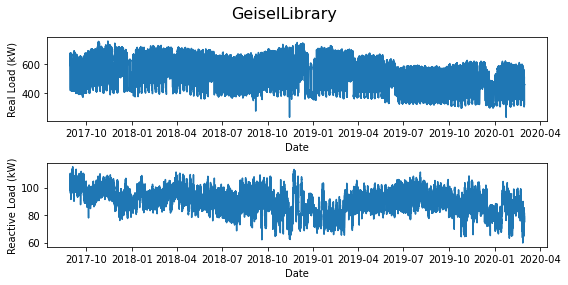

Reading: Building Load Data/OttersonHall.csv
(155609, 3)


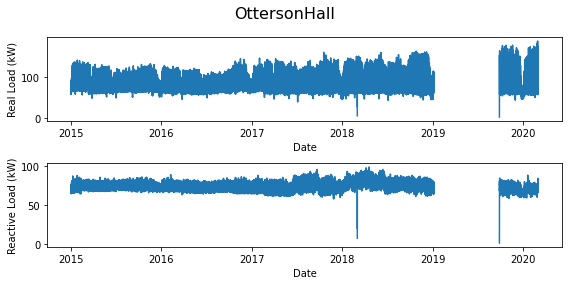

Reading: Building Load Data/StudentServices.csv
(131269, 3)


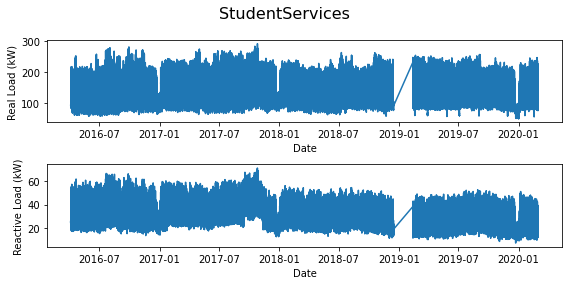

Reading: Building Load Data/Mandeville.csv
(180964, 3)


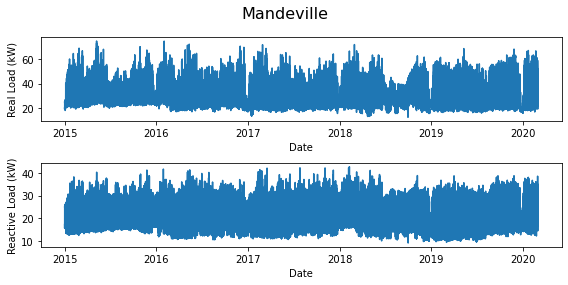

Reading: Building Load Data/RadyHall.csv
(181048, 3)


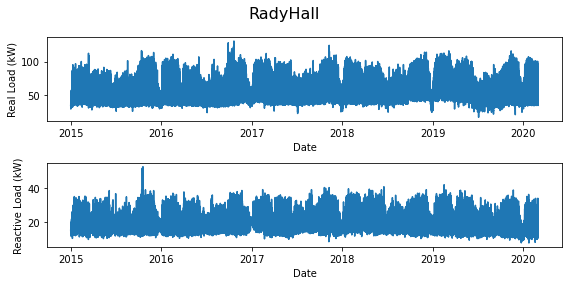

Reading: Building Load Data/RobinsonHall.csv
(141447, 3)


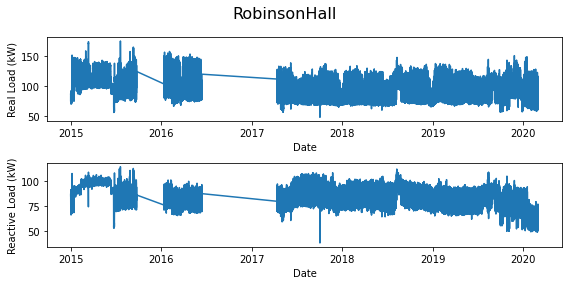

Reading: Building Load Data/SocialScience.csv
(113826, 3)


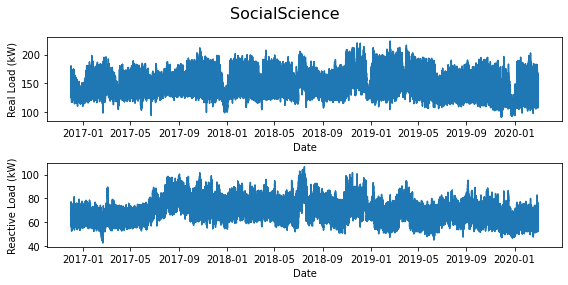

Reading: Building Load Data/CenterHall.csv
(145393, 3)


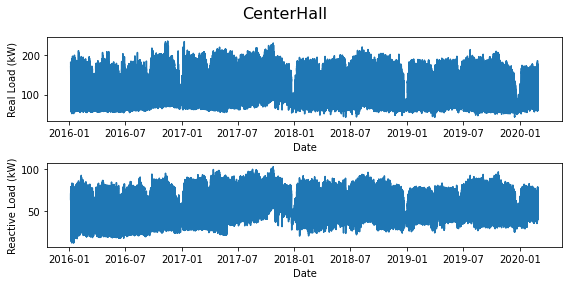

Reading: Building Load Data/PepperCanyon.csv
(177574, 3)


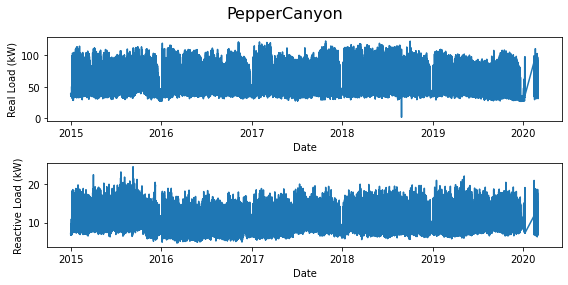

Reading: Building Load Data/GalbraithHall.csv
(181045, 3)


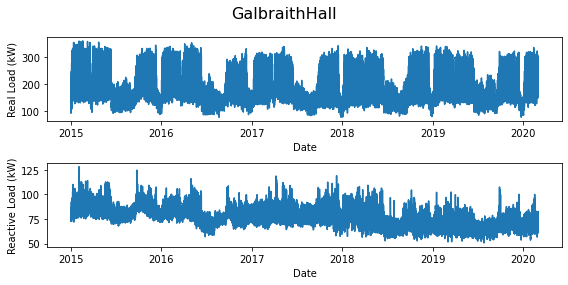

Reading: Building Load Data/MusicBuilding.csv
(122929, 3)


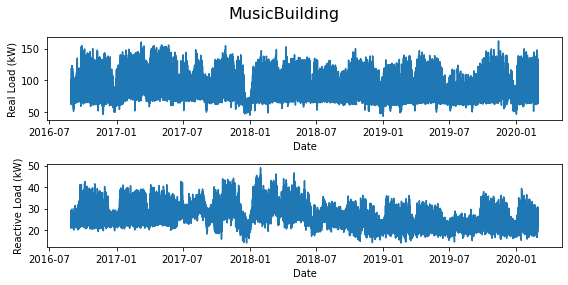

Reading: Building Load Data/EastCampus.csv
(92757, 3)


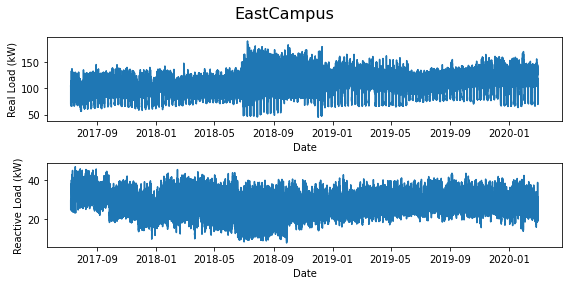

In [3]:
# Import building load data (takes about 3 minutes to read-in)
directory = 'Building Load Data'
real_load = pd.DataFrame()
reactive_load = pd.DataFrame()

# Iterate through all files in the directory
for file in os.listdir(directory):
    
    if file.endswith(".csv"):                                      # only iterate over csv files
        filepath = os.path.join(directory, file)                   # Get the full file path
        filename = os.path.splitext(os.path.basename(filepath))[0] # use filename as column name
        
        print("Reading:", filepath)
        data_in = pd.read_csv(filepath, parse_dates=['DateTime'])
        print(data_in.shape)

        fig, ax = plt.subplots(2, figsize=(8, 4)) 
        fig.suptitle(filename, fontsize=16) 

        ax[0].plot(data_in.iloc[:,0], data_in.iloc[:,1])
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Real Load (kW)')

        ax[1].plot(data_in.iloc[:,0], data_in.iloc[:,2])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Reactive Load (kW)')
        plt.tight_layout()
        plt.show()

        real_load[filename] = data_in.iloc[:, 1] # real power in column B of excel sheet
        reactive_load[filename] = data_in.iloc[:, 2] # real power in column C of excel sheet

In [4]:
# Get date column
for file in os.listdir(directory):
    if file.endswith(".csv"):                      # only iterate over csv files
        filepath = os.path.join(directory, file)   # Get the full file path
        data_in = pd.read_csv(filepath, parse_dates=['DateTime'])
        real_load['date'] = data_in.iloc[:, 0]     # only extract datetime
        reactive_load['date'] = data_in.iloc[:, 0] # only extract datetime
        break # only need to extract date column from one of the files

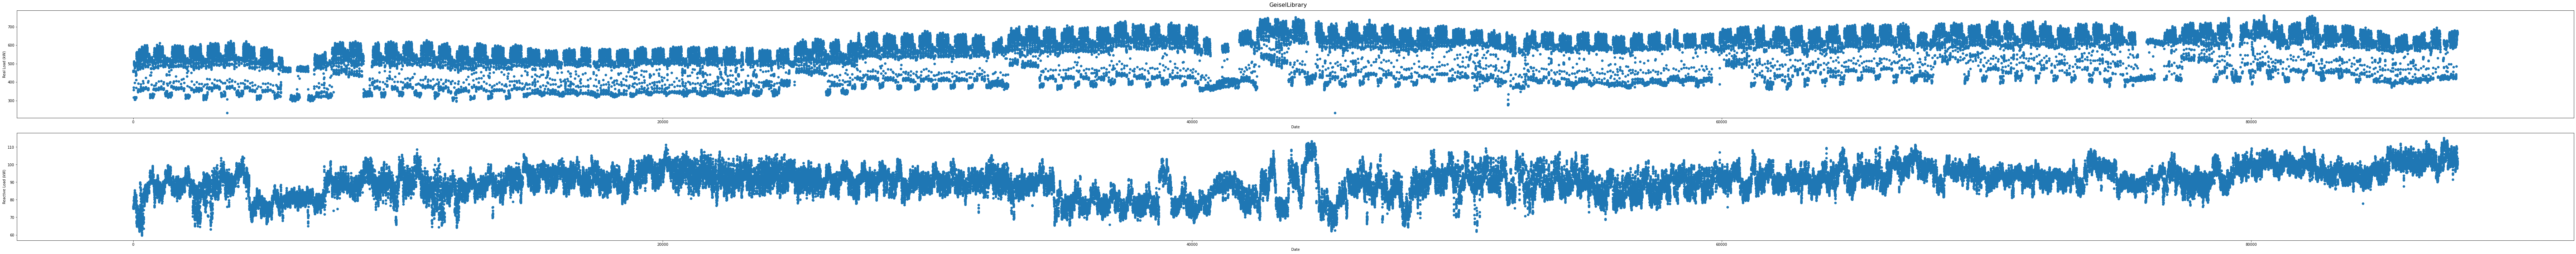

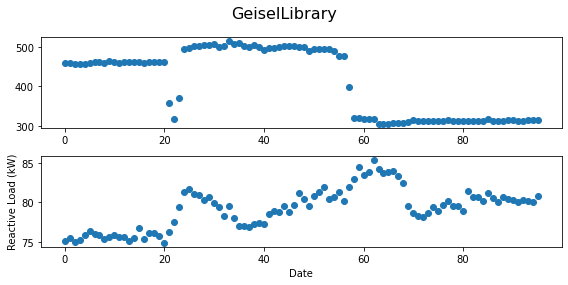

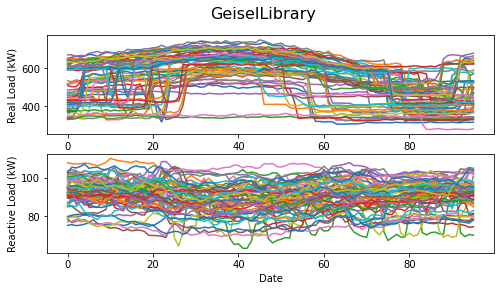

In [5]:
# Try to visualize the data (just try one building to start)

# Full time period
for column in real_load.columns:

    fig, ax = plt.subplots(2, figsize=(100, 10)) 
    fig.suptitle(column, fontsize=16) 

    ax[0].scatter(real_load.index, real_load[column])
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Real Load (kW)')

    ax[1].scatter(reactive_load.index, reactive_load[column])
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Reactive Load (kW)')
    plt.tight_layout()
    plt.show()

    break

# Approximately one day
for column in real_load.columns:
    
    fig, ax = plt.subplots(2, figsize=(8, 4)) 
    fig.suptitle(column, fontsize=16) 

    ax[0].scatter(range(96), real_load[column][0:96])
    

    ax[1].scatter(range(96), reactive_load[column][0:96])
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Reactive Load (kW)')
    plt.tight_layout()
    plt.show()

    break

# Plot multiple days for just one building (plot every 15 days, otherwise overwhelming)
num_data_points = real_load.shape[0]
day_length = 96 # data point every 15 minutes --> 4 points per hour, 24 hours per day
num_days = int(np.floor(num_data_points/day_length))

for column in real_load.columns:
    
    fig, ax = plt.subplots(2, figsize=(8, 4)) 
    fig.suptitle(column, fontsize=16)

    for day in range(0, num_days, 15):
        start = day_length * day
        end = start + day_length       
        
        ax[0].plot(range(0, day_length), real_load[column][start:end], label=f'day {day + 1}')
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Real Load (kW)')

        ax[1].plot(range(0, day_length), reactive_load[column][start:end])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Reactive Load (kW)')
    
    plt.show()
    
    break

In [6]:
# DECISION: 
# - Use 914 days worth of data starting from March 2015, because that is what is common across all of the buildings
# - For each building, collect the daily profiles into their own dataframe, with columns as days and rows as times
# - These profiles can be deterministically or randomly selected as the generation profile for a given day in the optimal control problem

real_dict = {}
reactive_dict = {}

for column in real_load.columns:
    real_data     = np.zeros([num_days, day_length])
    reactive_data = np.zeros([num_days, day_length])

    for day in range(num_days):
        start = day_length * day
        end = start + day_length       
        real_data[day, :]     = real_load[column][start:end]  
        reactive_data[day, :] = reactive_load[column][start:end]  

    real_dict[column] = real_data.tolist() # use LoL as numpy arrays are not json serializable
    reactive_dict[column] = reactive_data.tolist()

with open('Building Load Data/real_power_data.json', 'w') as json_file:
    json.dump(real_dict, json_file)

with open('Building Load Data/reactive_power_data.json', 'w') as json_file:
    json.dump(reactive_dict, json_file)

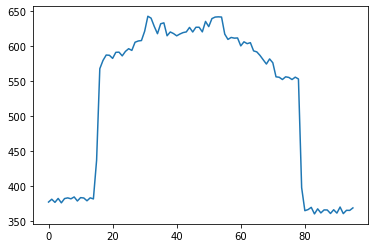

In [7]:
# Check that the json data was written correctly
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict_r = json.load(json_file)

    for key in real_dict_r.keys(): # test on first key only
        real_data = np.array(real_dict_r[key])
        plt.plot(range(real_data.shape[1]), real_data[422, :]) # e.g. for day 422
        break